In [3]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

# Auto-reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import pickle
import torch.nn as nn
import torchvision
import torch
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import jaccard_score
import torch.nn.functional

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def save_model(name: str, obj) -> None:
    with open(f"data/{name}.pckl", "wb") as f:
        pickle.dump(obj, f)


def load_model(name: str):
    with open(f"data/{name}.pckl", "rb") as f:
        return pickle.load(f)

# Image segmentation

Extend your ResNet18 implementation to include a segmentation capabilities. The simplest extension of a backbone network is to simply generate the predictions at the last convolutional feature layer and then upsample them to fit the input image dimensions as described in https://arxiv.org/pdf/1411.4038.pdf (FCN-32s). 

For this exercise you will be using the following dataset: https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge - You don't have to download it from kaggle as it is already hosted on drive (the script to download it is a few cells down).

For this task, implement the FCN-32s (https://arxiv.org/pdf/1411.4038.pdf), however this is one of the first and simplest fully convolutional segmentation networks and the results will be coarse. You can optionally extend your network with more complex segmentation heads.

A few network architecture that you can optionally implement to improve the results:
- the full FCN network described in https://arxiv.org/pdf/1411.4038.pdf 
- PSP-Net https://arxiv.org/pdf/1612.01105.pdf
- DeeplabV3 https://arxiv.org/pdf/1706.05587.pdf 


Additionally, implement the U-Net architecture https://arxiv.org/pdf/1505.04597.pdf and use it as a segmentation network. Compare it to your FCN-32s implementation.



# Network Implementation

## ResNet

In [6]:
class InputLayer(nn.Module):
    def __init__(self, inputs, outputs):
        super(InputLayer, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(inputs, outputs, 7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(outputs)
        self.maxpool = nn.MaxPool2d(inputs, stride=2, padding=1)

    def forward(self, x):
        return self.maxpool(self.relu(self.bn(self.conv(x))))


class HiddenLayer(nn.Module):
    def __init__(self, inputs, outputs, stride=1):
        super(HiddenLayer, self).__init__()
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(outputs)
        self.conv_1 = nn.Conv2d(inputs, outputs, 3, stride=stride, padding=1)
        self.conv_2 = nn.Conv2d(outputs, outputs, 3, stride=1, padding=1)

    def forward(self, x):
        rep_1 = self.relu(self.bn(self.conv_1(x)))
        rep_2 = self.relu(self.bn(self.conv_2(rep_1)))
        rep_3 = self.relu(self.bn(self.conv_2(rep_2)))
        return self.bn(self.conv_2(rep_3))


class FcnLayer(nn.Module):
    def __init__(self, outputs, num_classes):
        super(FcnLayer, self).__init__()
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(num_classes)
        self.conv_1 = nn.Conv2d(outputs, outputs, kernel_size=1)
        self.conv_2 = nn.Conv2d(outputs, num_classes, kernel_size=1)
        self.upsample = nn.ConvTranspose2d(
            13, 13, kernel_size=64, stride=32, dilation=1, padding=16
        )

    def forward(self, x):
        return self.upsample(self.conv_2(self.relu(self.conv_1(x))))


class ResNet18FCN(nn.Module):
    def __init__(self):
        super(ResNet18FCN, self).__init__()
        num_classes = 13

        self.relu = nn.ReLU()
        self.initial_layer = InputLayer(3, 64)
        self.layer_0 = HiddenLayer(64, 64)
        self.layer_1 = HiddenLayer(64, 128, 2)
        self.layer_2 = HiddenLayer(128, 256, 2)
        self.layer_3 = HiddenLayer(256, 512, 2)
        self.fcn_layer = FcnLayer(512, num_classes)

    def forward(self, x):
        i = self.initial_layer(x)
        l0 = self.layer_0(i)
        l1 = self.layer_1(l0)
        l2 = self.layer_2(l1)
        l3 = self.layer_3(l2)
        return self.fcn_layer(l3)

## UNet

In [19]:
class Conv2(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(Conv2, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ContractionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractionLayer, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), Conv2(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class ExpansionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpansionLayer, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = Conv2(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutputLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        num_classes = 13
        in_channels = 3
        self.output_dims = [320, 416]

        self.clayer_0 = Conv2(in_channels, 64)
        self.clayer_1 = ContractionLayer(64, 128)
        self.clayer_2 = ContractionLayer(128, 256)
        self.clayer_3 = ContractionLayer(256, 512)
        self.clayer_4 = ContractionLayer(512, 512)

        self.elayer_0 = ExpansionLayer(1024, 256)
        self.elayer_1 = ExpansionLayer(512, 128)
        self.elayer_2 = ExpansionLayer(256, 64)
        self.elayer_3 = ExpansionLayer(128, 64)
        self.output_layer = OutputLayer(64, num_classes)

    def forward(self, x):
        c0 = self.clayer_0(x)
        c1 = self.clayer_1(c0)
        c2 = self.clayer_2(c1)
        c3 = self.clayer_3(c2)
        c4 = self.clayer_4(c3)

        e0 = self.elayer_0(c4, c3)
        e1 = self.elayer_1(e0, c2)
        e2 = self.elayer_2(e1, c1)
        e3 = self.elayer_3(e2, c0)
        return self.output_layer(e3)


* `!pip install --upgrade --no-cache-dir gdown`
* *# !gdown --id 1Mgxe0Nl19hxMhQqVvEpaRDNd_L_RaLNM*
* `!gdown --id 1wUFws0e5ArlYUg7NZiAjjrYOmTGCX_Fv`

## Download the dataset
Download a part of the Lyft self driving dataset split into training and validation sets - https://www.kaggle.com/kumaresanmanickavelu/lyft-udacity-challenge 


The dataset contains 13 classes:
0 - unlabeled,
1 - building,
2 - fence,
3 - other
4 - pedestrian,
5 - pole
6 - road line
7 - road
8 - sidewalk
9 - vegetation
10 - car
11 - wall
12 - traffic sign






# Data Loader

In [2]:
from torch.utils.data import Dataset
import glob
import cv2
import numpy as np

class SegmentationDataset(Dataset):

    def __init__(self, train=True):
        dataset_path = "./data/seg_data/seg_data/" + ("train" if train else "test")
        self.images = sorted(glob.glob(dataset_path+"/*/*/CameraRGB/*.png"))
        self.masks = sorted(glob.glob(dataset_path+"/*/*/CameraSeg/*.png"))
        self.resize_shape = (320, 416)

    def __len__(self):
        return len(self.images)

    def transform_image(self, image_path, mask_path):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)[:,:,2]

        channels=3
        image = cv2.resize(image, dsize=(self.resize_shape[1], self.resize_shape[0]))
        mask = cv2.resize(mask, dsize=(self.resize_shape[1], self.resize_shape[0]))
        image = np.array(image).reshape((image.shape[0], image.shape[1], channels)).astype(np.float32) / 255.0
        mask = np.array(mask).reshape((image.shape[0], image.shape[1], 1))

        image = np.transpose(image, (2, 0, 1))
        mask = np.transpose(mask, (2, 0, 1))
        return image, mask

    def __getitem__(self, idx):
        image, mask = self.transform_image(self.images[idx], self.masks[idx])
        sample = {'image': image, "mask": mask, 'idx': idx}

        return sample

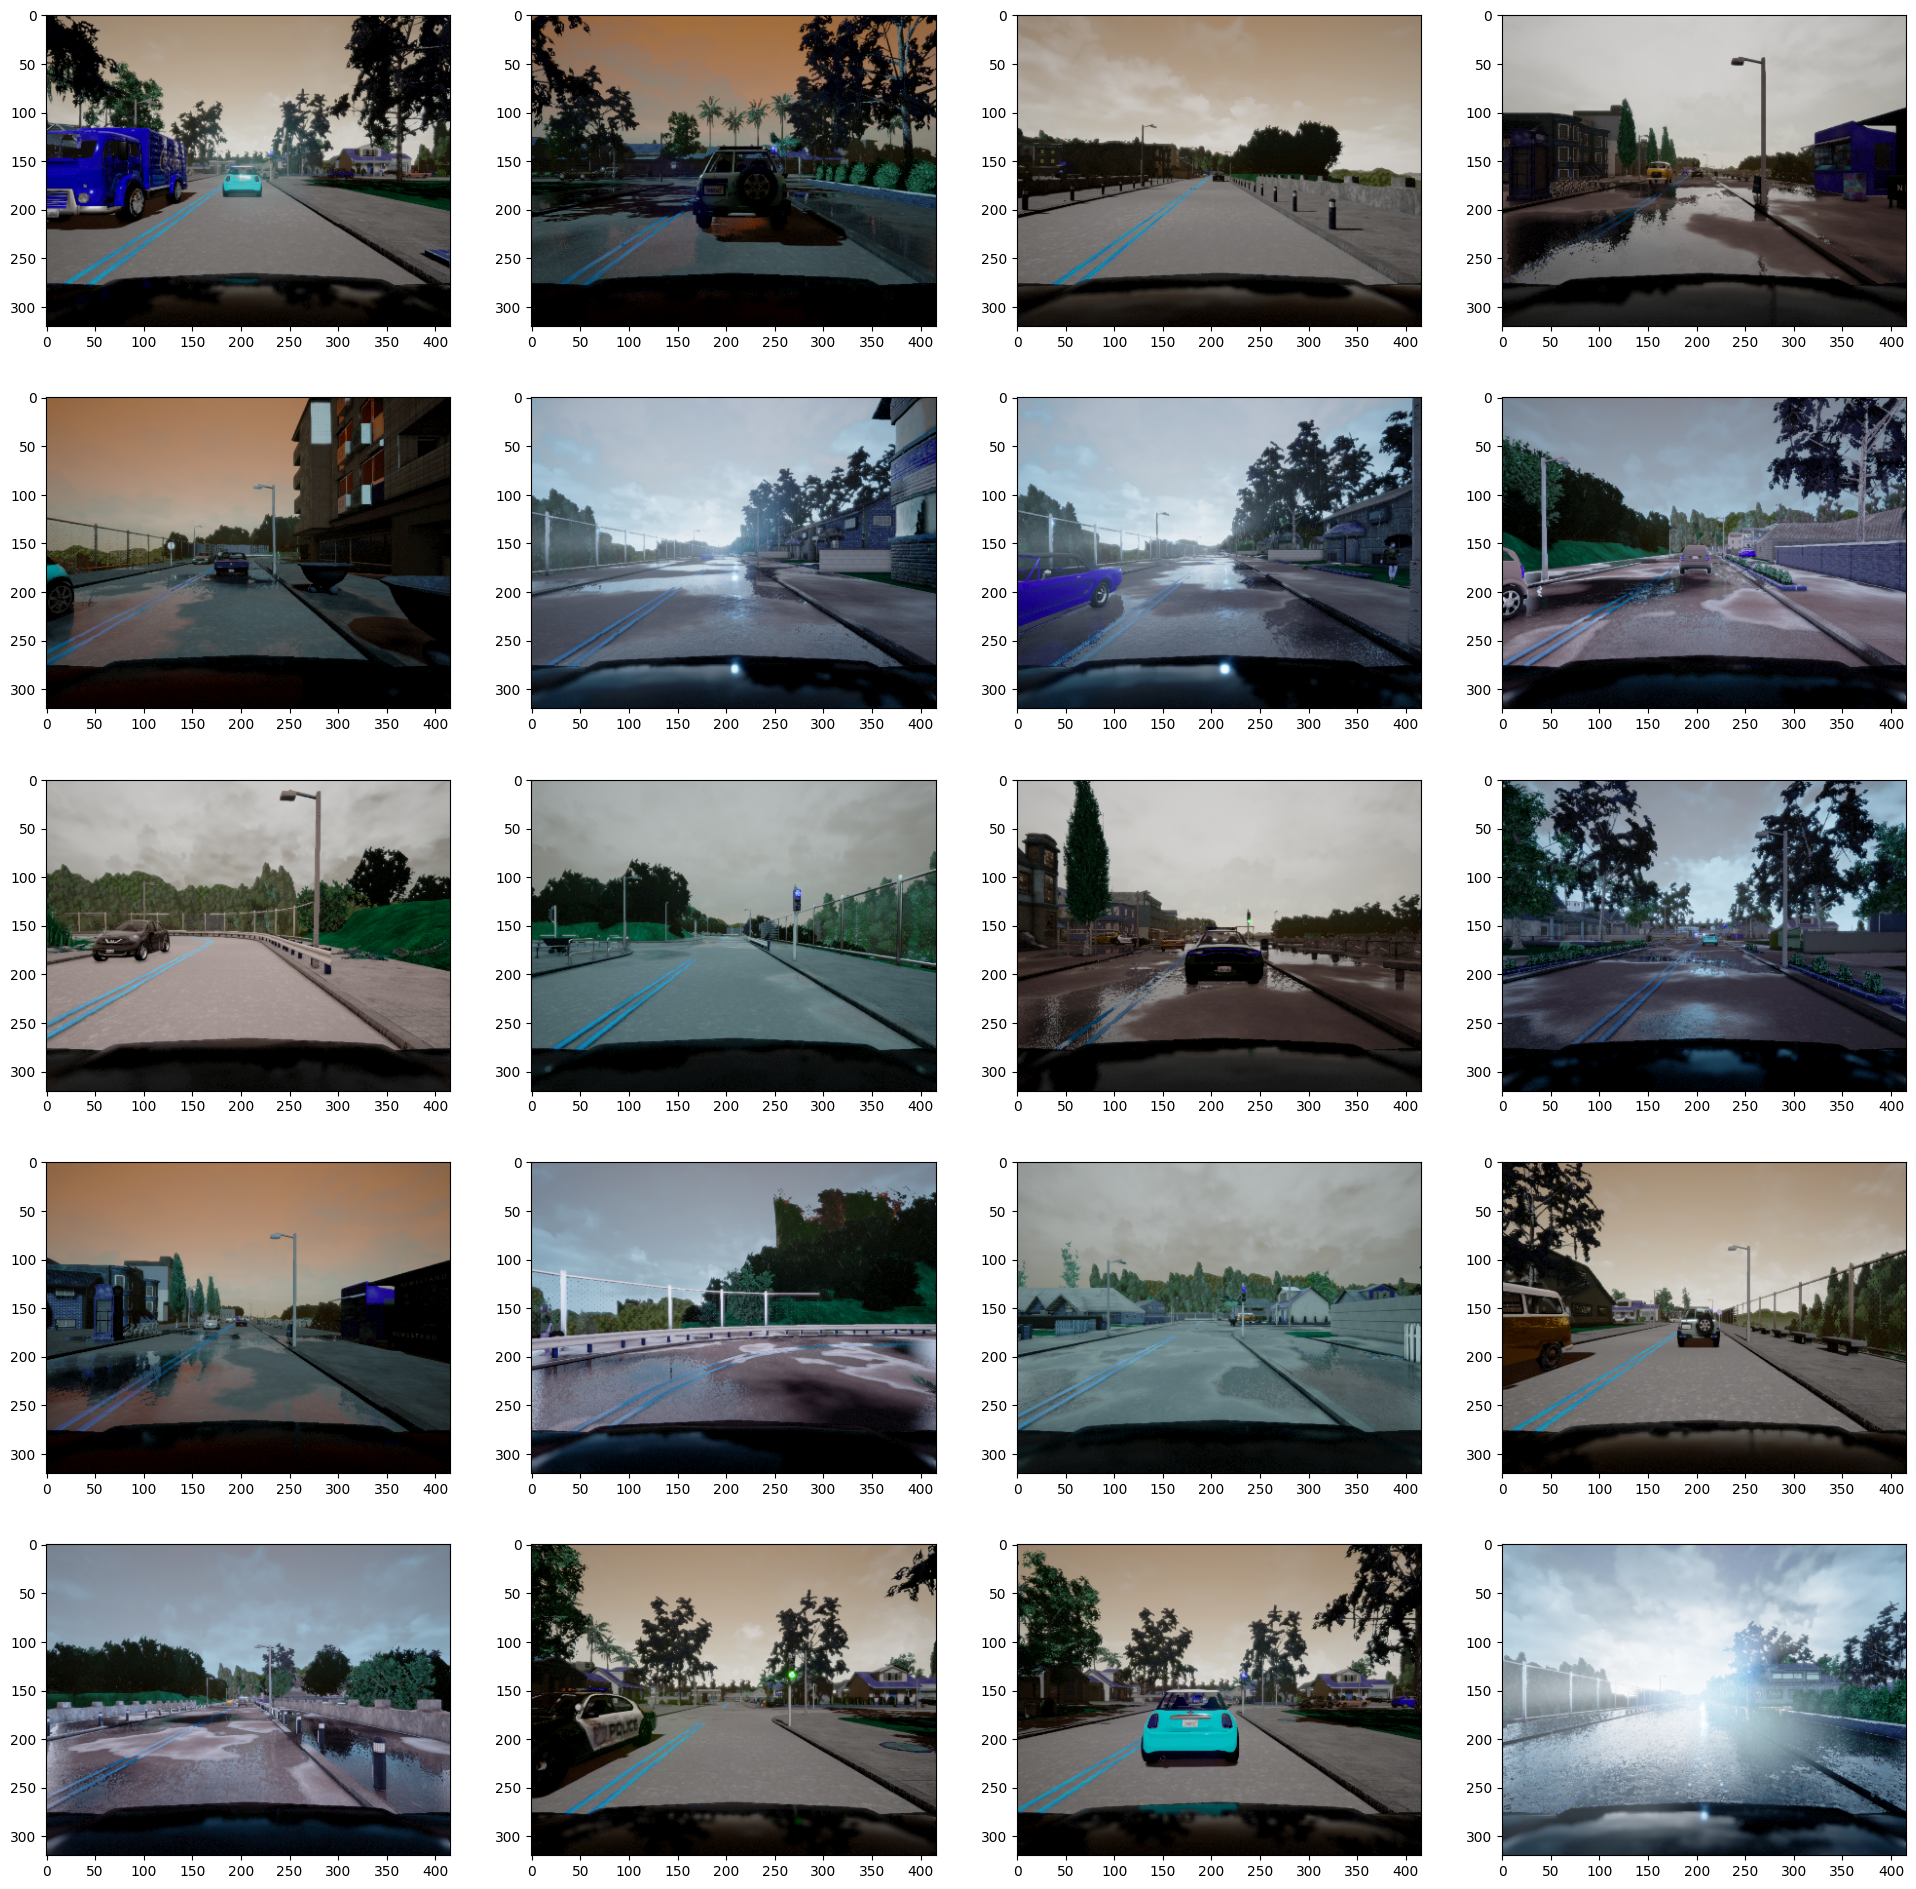

In [7]:
trainset = SegmentationDataset(train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = SegmentationDataset(train=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

import matplotlib.pyplot as plt
import numpy as np
fig=plt.figure(figsize=(24, 24))
columns = 4
rows = 5
for i in range(rows*columns):
  data = trainset[np.random.randint(len(trainset))]
  input = data["image"]
  label = data["mask"]
  img = input.transpose((1,2,0))
  ax = fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
plt.show()


In [30]:
def train_resnet_fcn(epochs, lr):
    net = ResNet18FCN()
    net.cuda()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(net.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(epochs):  # loop over the dataset multiple times
        with tqdm(
            total=len(trainset),
            desc=str(epoch) + "/" + str(epochs),
            miniters=int(50),
            unit="img",
        ) as prog_bar:
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs = data["image"]
                labels = data["mask"]
                inputs = inputs.cuda()
                labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0, :, :].long())
                loss.backward()
                optimizer.step()

                prog_bar.set_postfix(
                    **{"loss": np.round(loss.data.cpu().detach().numpy(), 5)}
                )
                prog_bar.update(4)
            # scheduler.step()
    return net

In [31]:
net = train_resnet_fcn(5, 0.0001)

0/5:   0%|          | 0/4000 [00:00<?, ?img/s]

1/5:   0%|          | 0/4000 [00:00<?, ?img/s]

2/5:   0%|          | 0/4000 [00:00<?, ?img/s]

3/5:   0%|          | 0/4000 [00:00<?, ?img/s]

4/5:   0%|          | 0/4000 [00:00<?, ?img/s]

## Evaluate on the test set:

Implement the evaluation on the test set. Use the mean IOU metric to evaluate the result. - https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation 



In [29]:
def test_model(net, curr_data_loader):
    num_images = len(curr_data_loader.dataset)
    net.eval()
    jacSum = 0
    with torch.no_grad():
        for _, data in enumerate(testloader, 0):
            images = data["image"]
            labels = data["mask"]
            images = images.cuda()
            labels = labels.cuda()
            
            outputs = net(images)
            _, y_pred = torch.max(outputs.data, 1)
            y = labels.detach().cpu().numpy().reshape(-1)
            y_pred = y_pred.detach().cpu().numpy().reshape(-1)
            jacSum += jaccard_score(y, y_pred, average="macro")
    print("IUO: ", jacSum / num_images)

IUO:  0.053995594907934104


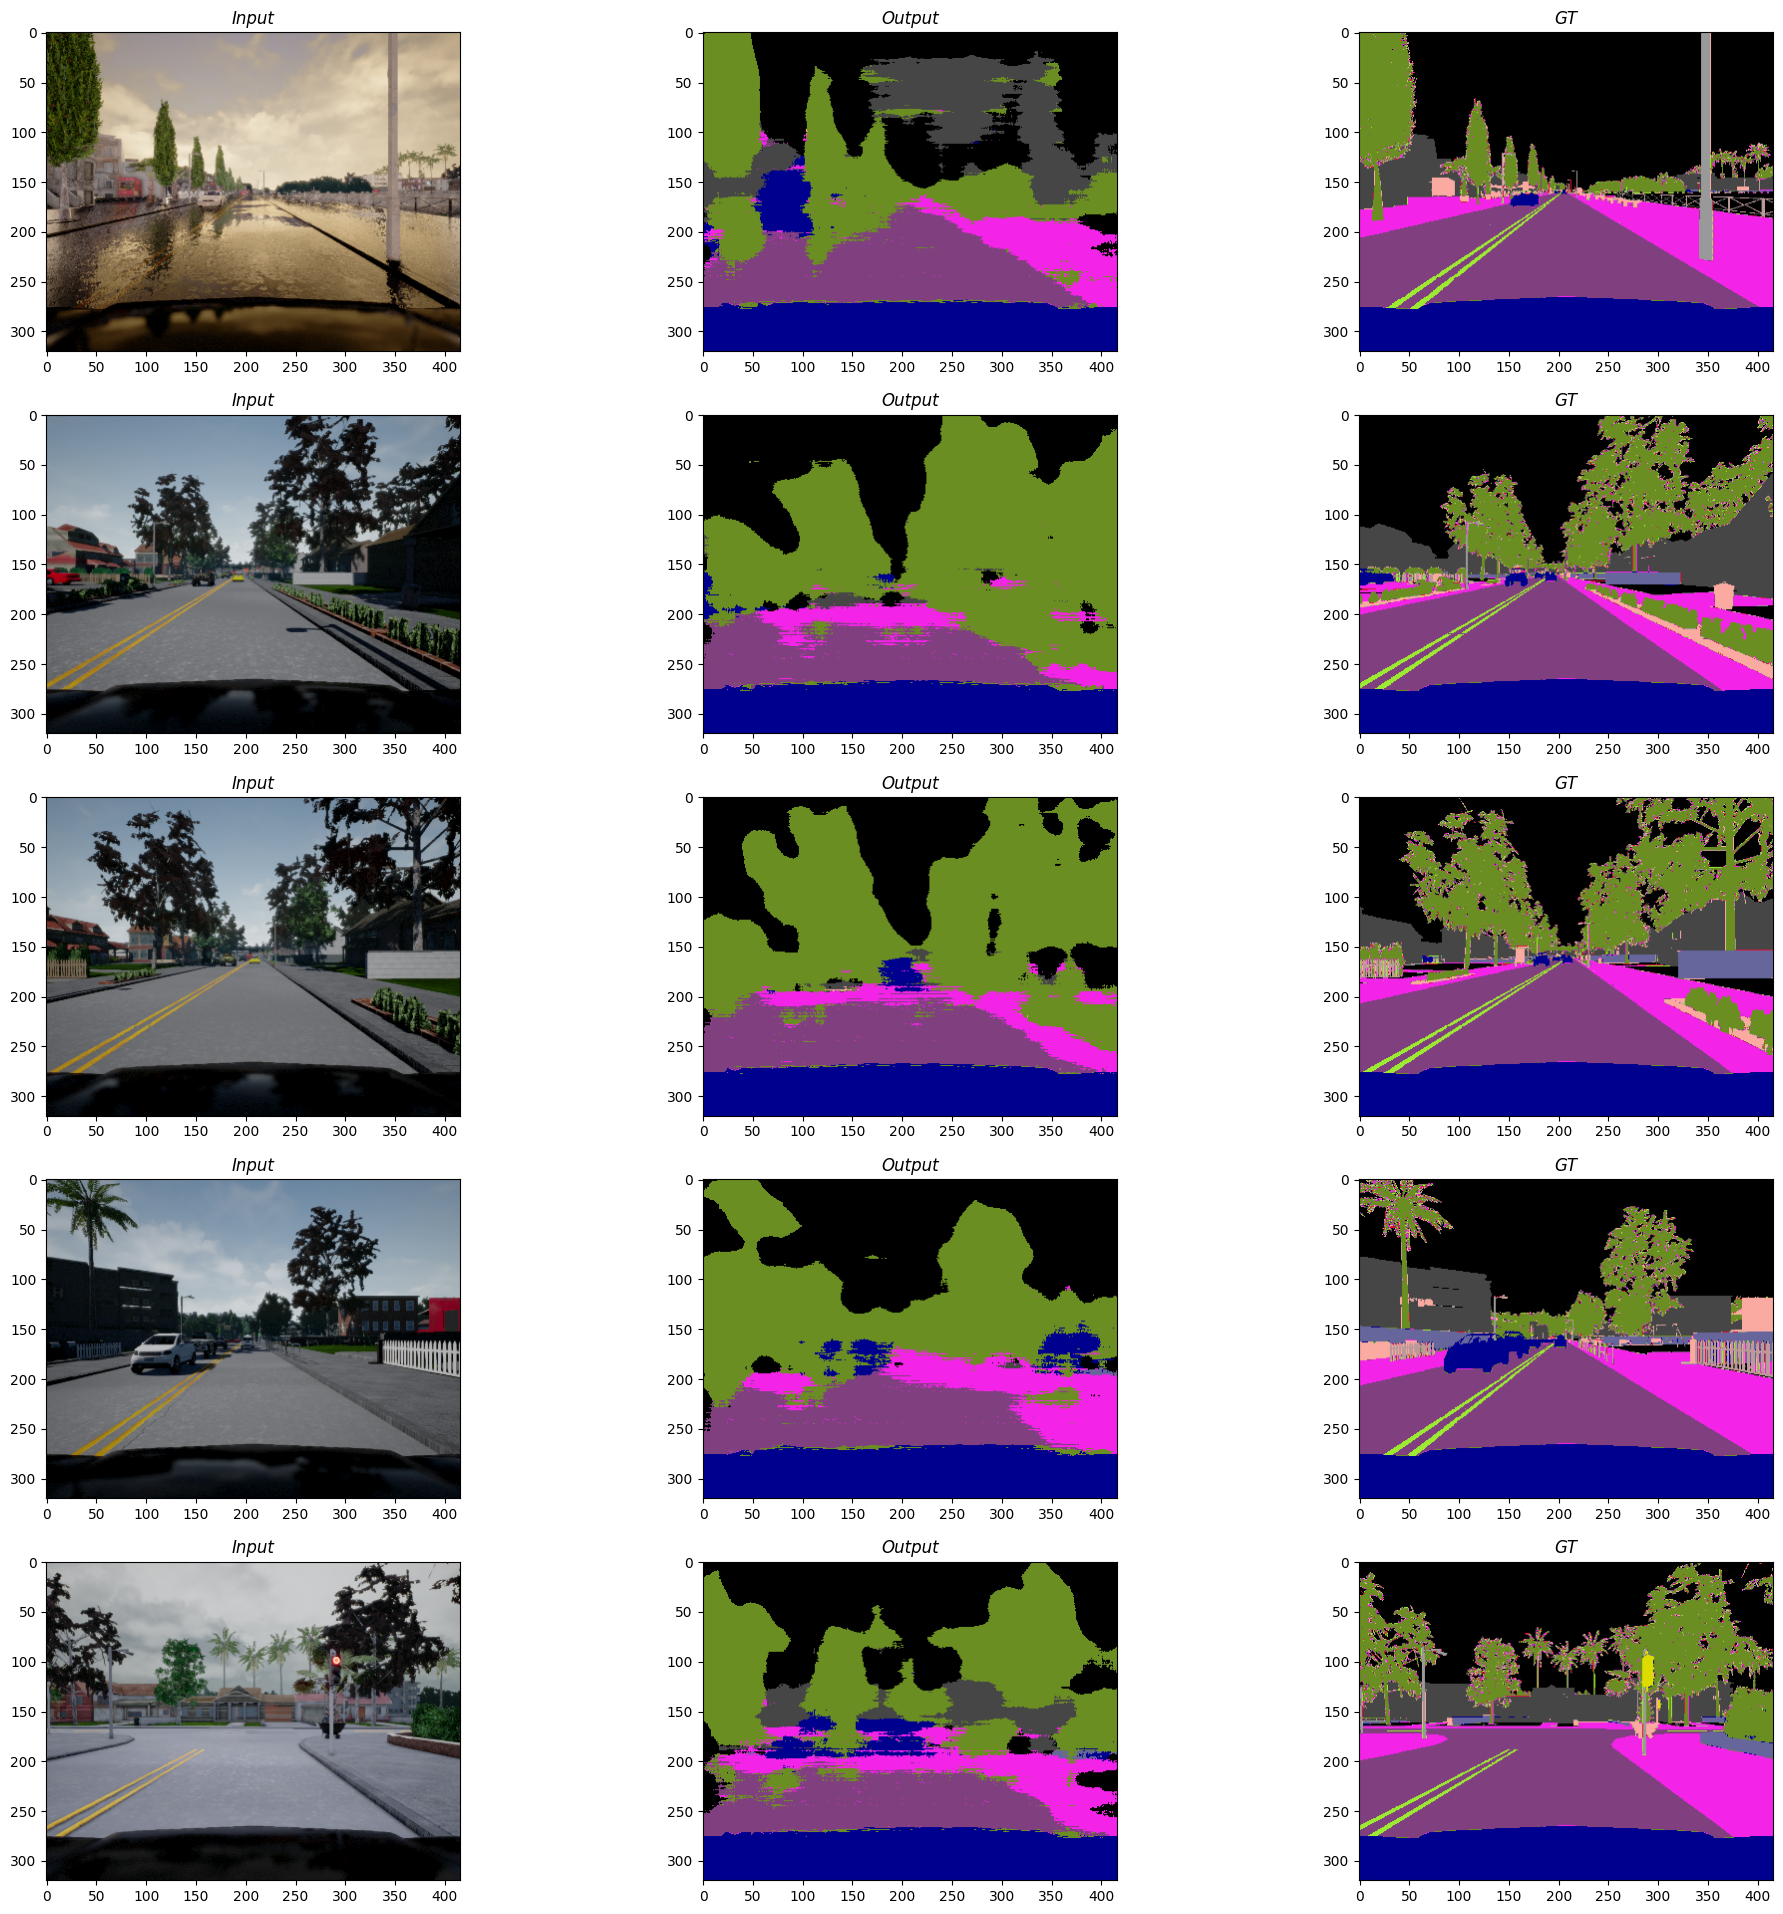

In [32]:
import matplotlib.pyplot as plt

label_colors = np.array(
    [
        [0, 0, 0],  # unlabeled
        [70, 70, 70],  # building
        [190, 153, 153],  # fence
        [250, 170, 160],  # other
        [220, 20, 60],  # pedestrian
        [153, 153, 153],  # pole
        [157, 234, 50],  # road line
        [128, 64, 128],  # road
        [244, 35, 232],  # sidewalk
        [107, 142, 35],  # vegetation
        [0, 0, 142],  # car
        [102, 102, 156],  # wall
        [220, 220, 0],  # traffic sign
    ]
)


net.eval()
test_model(net, testloader)

fig = plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
    batch = testset[np.random.randint(len(testset))]
    img = batch["image"]
    labels = batch["mask"]
    img_tensor = torch.from_numpy(img).cuda()
    img_tensor = img_tensor.unsqueeze(0)
    outputs = net(img_tensor)
    out_image = outputs[0, :, :, :].detach().cpu().numpy()
    seg_mask = np.argmax(out_image, axis=0)
    seg_mask_color = label_colors[seg_mask]
    gt_mask_color = label_colors[labels[0, :, :]]

    img = img.transpose((1, 2, 0))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    labels = labels[0, :, :]
    ax = fig.add_subplot(rows, columns, i * columns + 1)
    ax.set_title("Input", fontstyle="italic")
    plt.imshow(img)
    ax = fig.add_subplot(rows, columns, i * columns + 2)
    ax.set_title("Output", fontstyle="italic")
    plt.imshow(seg_mask_color)
    ax = fig.add_subplot(rows, columns, i * columns + 3)
    ax.set_title("GT", fontstyle="italic")
    plt.imshow(gt_mask_color)


plt.show()

In [11]:
def train_unet(epochs, lr):
    net = UNet()
    net.cuda()

    # Define the loss function
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(epochs):  # loop over the dataset multiple times
        with tqdm(
            total=len(trainset),
            desc=str(epoch) + "/" + str(epochs),
            miniters=int(50),
            unit="img",
        ) as prog_bar:
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs = data["image"]
                labels = data["mask"]
                inputs = inputs.cuda()
                labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels[:, 0, :, :].long())
                loss.backward()
                optimizer.step()

                prog_bar.set_postfix(
                    **{"loss": np.round(loss.data.cpu().detach().numpy(), 5)}
                )
                prog_bar.update(4)
            scheduler.step()
    return net

In [ ]:
save_model("high_res_unet", net)

In [20]:
net = train_unet(5, 0.0001)

IUO:  0.2320625342033446


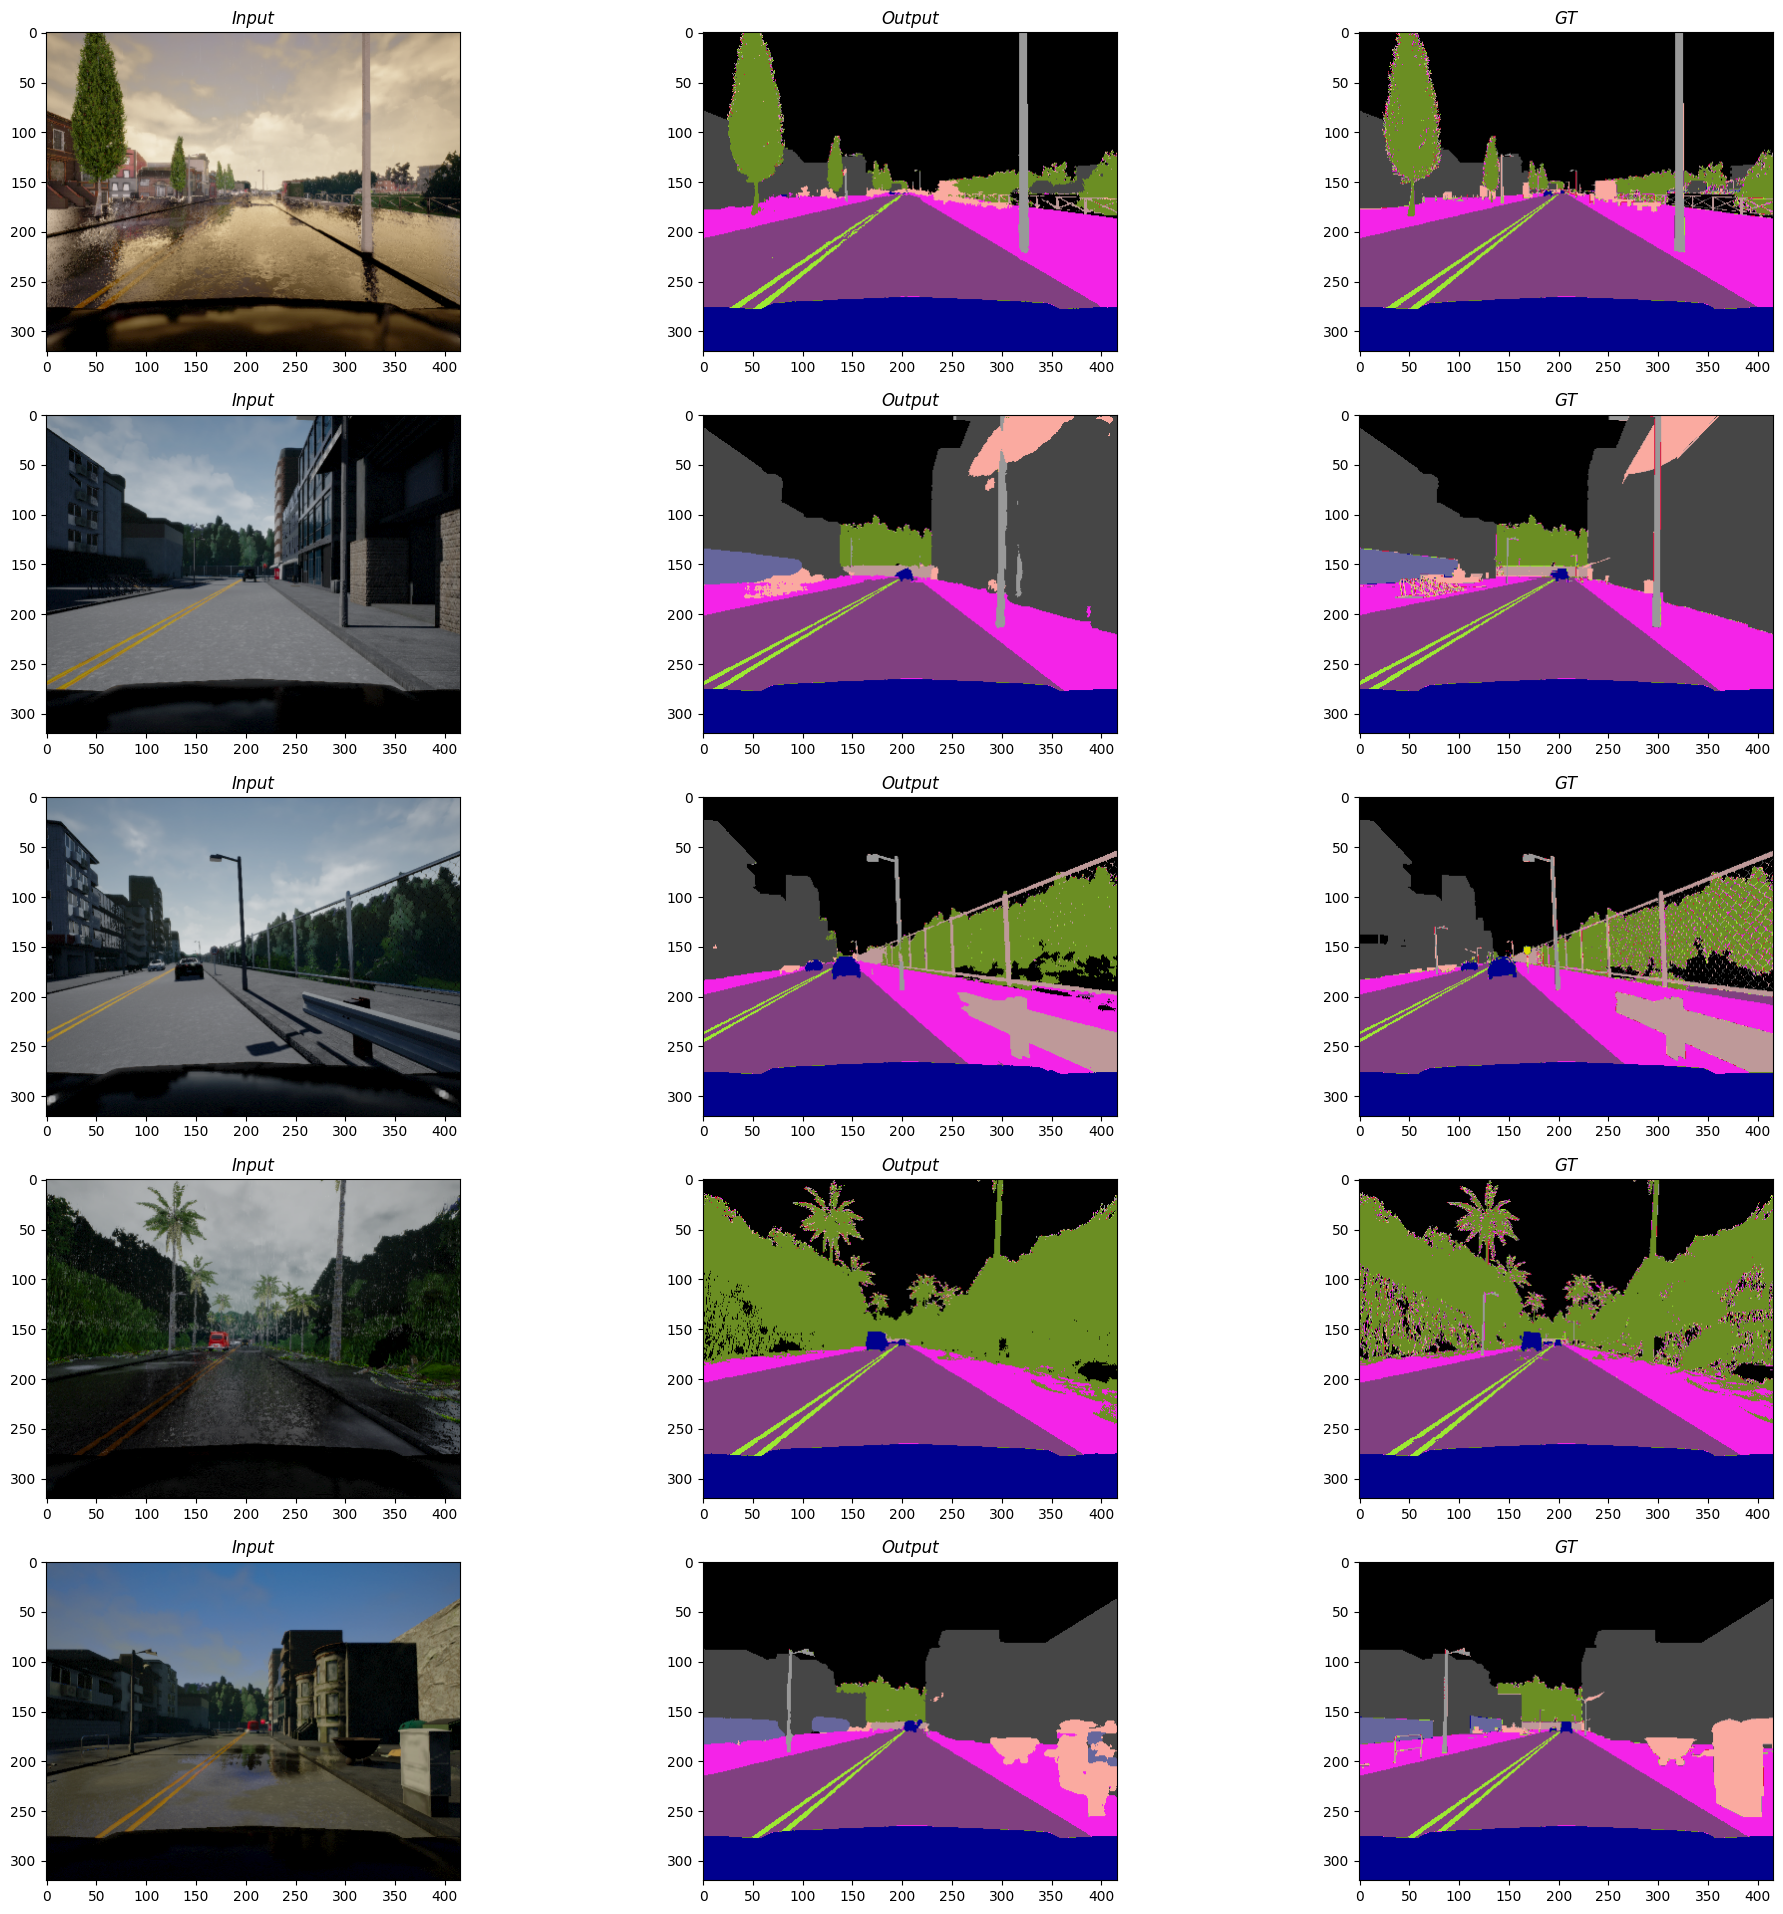

In [21]:
import matplotlib.pyplot as plt

label_colors = np.array(
    [
        [0, 0, 0],  # unlabeled
        [70, 70, 70],  # building
        [190, 153, 153],  # fence
        [250, 170, 160],  # other
        [220, 20, 60],  # pedestrian
        [153, 153, 153],  # pole
        [157, 234, 50],  # road line
        [128, 64, 128],  # road
        [244, 35, 232],  # sidewalk
        [107, 142, 35],  # vegetation
        [0, 0, 142],  # car
        [102, 102, 156],  # wall
        [220, 220, 0],  # traffic sign
    ]
)


net.eval()
test_model(net, testloader)

fig = plt.figure(figsize=(24, 24))
columns = 3
rows = 5
for i in range(rows):
    batch = testset[np.random.randint(len(testset))]
    img = batch["image"]
    labels = batch["mask"]
    img_tensor = torch.from_numpy(img).cuda()
    img_tensor = img_tensor.unsqueeze(0)
    outputs = net(img_tensor)
    out_image = outputs[0, :, :, :].detach().cpu().numpy()
    seg_mask = np.argmax(out_image, axis=0)
    seg_mask_color = label_colors[seg_mask]
    gt_mask_color = label_colors[labels[0, :, :]]

    img = img.transpose((1, 2, 0))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    labels = labels[0, :, :]
    ax = fig.add_subplot(rows, columns, i * columns + 1)
    ax.set_title("Input", fontstyle="italic")
    plt.imshow(img)
    ax = fig.add_subplot(rows, columns, i * columns + 2)
    ax.set_title("Output", fontstyle="italic")
    plt.imshow(seg_mask_color)
    ax = fig.add_subplot(rows, columns, i * columns + 3)
    ax.set_title("GT", fontstyle="italic")
    plt.imshow(gt_mask_color)


plt.show()